In [1]:
from datetime import datetime
print(f'Päivitetty {datetime.now()}')

Päivitetty 2022-09-11 12:52:08.931765


# Luokittelu - kategorisia muuttujia, tasapainotus

Data löytyy esimerkiksi lähteestä:
https://archive.ics.uci.edu/ml/datasets/bank+marketing

Kohdemuuttuja y sisältää tiedon siitä, onko asiakkaalla määräaikaistalletuksia.

Selvitetään voidaanko asiakastietojen perusteella ennustaa y-muuttujan arvoja.

Mukana on kategorisia muuttujia, jotka täytyy muuntaa dummy-muuttujiksi.

In [2]:
import pandas as pd

# Datan tasapainottamiseen
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Datan kaikki sarakkeet näkyviin
pd.options.display.max_columns = None

## Datan tarkastelua

In [3]:
df = pd.read_csv('https://taanila.fi/banking.csv')
df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,44,blue-collar,married,basic.4y,unknown,yes,no,cellular,aug,thu,210,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0
1,53,technician,married,unknown,no,no,no,cellular,nov,fri,138,1,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,0
2,28,management,single,university.degree,no,yes,no,cellular,jun,thu,339,3,6,2,success,-1.7,94.055,-39.8,0.729,4991.6,1
3,39,services,married,high.school,no,no,no,cellular,apr,fri,185,2,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,0
4,55,retired,married,basic.4y,no,yes,no,cellular,aug,fri,137,1,3,1,success,-2.9,92.201,-31.4,0.869,5076.2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,59,retired,married,high.school,unknown,no,yes,telephone,jun,thu,222,1,999,0,nonexistent,1.4,94.465,-41.8,4.866,5228.1,0
41184,31,housemaid,married,basic.4y,unknown,no,no,telephone,may,thu,196,2,999,0,nonexistent,1.1,93.994,-36.4,4.860,5191.0,0
41185,42,admin.,single,university.degree,unknown,yes,yes,telephone,may,wed,62,3,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
41186,48,technician,married,professional.course,no,no,yes,telephone,oct,tue,200,2,999,0,nonexistent,-3.4,92.431,-26.9,0.742,5017.5,0


In [4]:
# Kohdemuuttujan jakaumasta nähdään, että dataa kannattaa tasapainottaa
df['y'].value_counts()

0    36548
1     4640
Name: y, dtype: int64

## Muuttujien muunnokset

In [5]:
df['education'].unique()

array(['basic.4y', 'unknown', 'university.degree', 'high.school',
       'basic.9y', 'professional.course', 'basic.6y', 'illiterate'],
      dtype=object)

In [6]:
# education-muuttujan uudelleenkoodaus
df['education'] = df['education'].replace({'basic.4y':'basic', 'basic.6y':'basic', 'basic.9y':'basic'})
df['education'].unique()

array(['basic', 'unknown', 'university.degree', 'high.school',
       'professional.course', 'illiterate'], dtype=object)

In [7]:
# Kategoriset muuttujat dummy-muuttujiksi
df_dummies = pd.get_dummies(df)
df_dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 62 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            41188 non-null  int64  
 1   duration                       41188 non-null  int64  
 2   campaign                       41188 non-null  int64  
 3   pdays                          41188 non-null  int64  
 4   previous                       41188 non-null  int64  
 5   emp_var_rate                   41188 non-null  float64
 6   cons_price_idx                 41188 non-null  float64
 7   cons_conf_idx                  41188 non-null  float64
 8   euribor3m                      41188 non-null  float64
 9   nr_employed                    41188 non-null  float64
 10  y                              41188 non-null  int64  
 11  job_admin.                     41188 non-null  uint8  
 12  job_blue-collar                41188 non-null 

## Tasapainotus ja mallien sovittaminen

In [8]:
X = df_dummies.drop('y', axis=1)
y = df_dummies['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2)

In [9]:
# Sovitetaan gradienttitehostus ilman datan tasapainotusta
gbc1 = GradientBoostingClassifier(max_depth=3, random_state=2)
gbc1.fit(X_train, y_train)

# Tasapainotus RandomOverSampler + gradienttitehostus
# RandomOverSampler kasvattaa satunnaisotoksilla pienempää ryhmää
ros = RandomOverSampler(random_state=2)
X_train2, y_train2 = ros.fit_resample(X_train, y_train)
gbc2 = GradientBoostingClassifier(max_depth=3, random_state=2)
gbc2.fit(X_train2, y_train2)

# Tasapainotus RandomUnderSampler + gradienttitehostus
# RandomUnderSampler pienentää satunnaisotoksilla isompaa ryhmää
rus = RandomUnderSampler(random_state=2)
X_train3, y_train3 = rus.fit_resample(X_train, y_train)
gbc3 = GradientBoostingClassifier(max_depth=3, random_state=2)
gbc3.fit(X_train3, y_train3)

GradientBoostingClassifier(random_state=2)

## Mallien arviointia

In [10]:
# Oikeaan osuneiden ennusteiden osuus opetusdatassa
print(f'Ilman tasapainotusta {gbc1.score(X_train, y_train):.3f}')
print(f'RandomOverSampler {gbc2.score(X_train, y_train):.3f}')
print(f'RandomUnderSampler {gbc3.score(X_train, y_train):.3f}')

Ilman tasapainotusta 0.923
RandomOverSampler 0.861
RandomUnderSampler 0.860


In [11]:
# Oikeaan osuneiden ennusteiden osuus testidatassa
print(f'Ilman tasapainostusta {gbc1.score(X_test, y_test):.3f}')
print(f'RandomOverSampler {gbc2.score(X_test, y_test):.3f}')
print(f'RandomUnderSampler {gbc3.score(X_test, y_test):.3f}')

Ilman tasapainostusta 0.915
RandomOverSampler 0.854
RandomUnderSampler 0.854


In [12]:
# Mallien antamat ennusteet testidatalle
y_pred1 = gbc1.predict(X_test)
y_pred2 = gbc2.predict(X_test)
y_pred3 = gbc3.predict(X_test)

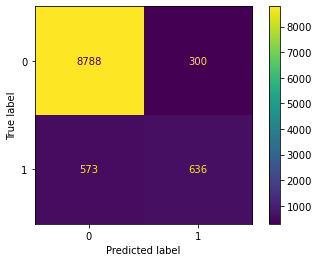

In [13]:
# Sekaannusmatriisi ilman tasapainotusta
cm = confusion_matrix(y_test, y_pred1)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

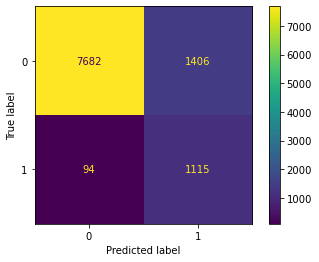

In [14]:
# Sekaannusmatriisi (tasapainotus RandomOverSampler)
cm = confusion_matrix(y_test, y_pred2)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

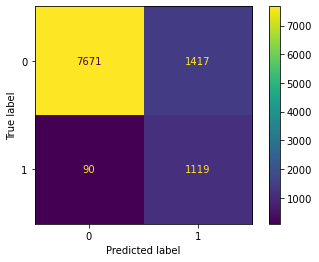

In [15]:
# Sekaannusmatriisi (tasapainotus RandomUnderSampler)
cm = confusion_matrix(y_test, y_pred3)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

Jos tarkoituksena on poimia uudesta datasta niitä, jotka todennäköisimmin tekisivät määräaikaistalletuksia, niin RandomUnderSampler+gradienttitehostus vaikuttaisi parhaalta mallilta. Se tunnistaa testidatasta suurimman osan määräaikaistalletuksia tehneistä.